# Collate Data

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import scipy as sc
import seaborn as sns

In [21]:
import rasterio as rio
import rasterio.warp

In [2]:
import tqdm
#from tqdm import tqdm
from tqdm.notebook import tqdm # for notebooks
tqdm.pandas()

In [3]:
import pickle
import gc
collectAll = lambda : gc.collect(0) + gc.collect(1) + gc.collect(2)

In [4]:
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [5]:
from collections import namedtuple
import itertools
from itertools import product

In [6]:
from skimage.feature import graycomatrix
from skimage.feature import graycoprops
from math import pi

In [7]:
import PIL as pil
from PIL import Image, ImageDraw

In [8]:
#import papermill as pm

In [9]:
import math

In [15]:
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


## Bounds

### Load bounds

In [10]:
df1 = pd.read_csv("geotiffs/10May2021/bounds.csv", sep='|')
df2 = pd.read_csv("geotiffs/18Dec2020/bounds.csv", sep='|')
df1['src'] = "10May2021"
df2['src'] = "18Dec2020"
df = pd.concat((df1, df2)).reset_index()

### Load rasters and georeference.

In [11]:
bands = ['wr', 'wg', 'wb', 'r', 'g', 'b', 'nir', 'red_edge', 'ndvi', 'chm']
props = ['mean_no_glcm', 'mean', 'contrast', 'dissimilarity', 'homogeneity', 'ASM', 'energy', 'correlation']

In [31]:
def load_rasters(prefix):
    prefix = 'geotiffs/' + prefix + '/'

    wrwgwb = prefix + 'result.tif'

    r = prefix + 'result_Red.tif'
    g = prefix + 'result_Green.tif'
    b = prefix + 'result_Blue.tif'

    nir = prefix + 'result_NIR.tif'
    red_edge = prefix + 'result_RedEdge.tif'

    dsm = prefix + 'dsm.tif'

    raster_ds = rio.open(wrwgwb)
    dsm_ds = rio.open(dsm)

    arr = np.stack(
        [i for i in rio.open(wrwgwb).read()[:3]] +
        [rio.open(i).read()[0] for i in [r, g, b, nir, red_edge]], axis=2)
    arr = arr.astype('float32')
    arr[arr <= 0] = np.nan

    arr = np.ma.MaskedArray(arr,
                            np.isnan(arr))
    arr.fill_value = np.nan

    red = arr[:,:,bands.index('r')]
    nir = arr[:,:,bands.index('nir')]
    ndvi = np.expand_dims((nir - red) / (nir + red), axis=2)
    arr = np.concatenate((arr, ndvi), axis=2)

    dsm_coreg_shape = arr.shape[:2]
    dsm_coreg = np.empty(dsm_coreg_shape)
    dsm = np.nan_to_num(dsm_ds.read()[0])
    dsm[dsm <= 0] = np.nan

    rio.warp.reproject(
        source=dsm,
        destination=dsm_coreg,
        src_transform=dsm_ds.transform,
        src_crs=dsm_ds.crs,
        src_nodata=np.nan,
        dst_transform=raster_ds.transform,
        dst_crs=raster_ds.crs,
        dst_nodata=np.nan
    )
            
    dsm_coreg = np.expand_dims(dsm_coreg, axis=2)
    arr = arr.data
    arr = np.concatenate((arr, dsm_coreg), axis=2)
    
    return arr

img_18Dec2020 = load_rasters('18Dec2020')
img_10May2021 = load_rasters('10May2021')


KeyboardInterrupt



### Save fused multispectral and CHM

In [29]:
np.save('img_18Dec2020.npy', img_18Dec2020)

In [30]:
np.save('img_10May2021.npy', img_10May2021)

### Reload

In [32]:
img_18Dec2020 = np.load('img_18Dec2020.npy')

In [33]:
img_10May2021 = np.load('img_10May2021.npy')

In [63]:
bands = ['wr', 'wg', 'wb', 'r', 'g', 'b', 'nir', 'red_edge', 'ndvi', 'chm']
bands_readable = {
    'wr': 'Wideband Red',
    'wb': 'Wideband Blue',
    'wg': 'Wideband Green',
    'r': 'Red',
    'b': 'Blue',
    'g': 'Green',
    'nir': 'NIR',
    'red_edge': 'Red Edge',
    'ndvi': 'NDVI',
    'chm': 'CHM'
}
props = ['mean_no_glcm', 'mean', 'contrast', 'dissimilarity', 'homogeneity', 'ASM', 'energy', 'correlation']

In [35]:
for image in [img_18Dec2020, img_10May2021]:
    image[:,:,bands.index('chm')][image[:,:,bands.index('chm')]<0] = float('nan')

In [36]:
collectAll()

843

### Georeference ITCs in dataframe

In [42]:
df['crop'] = None
for idx, row in df.iterrows():
    if row['src'] == '10May2021':
        img = img_10May2021
    else:
        img = img_18Dec2020
    df.at[idx, 'crop'] = img[row['y0']:row['y1'],row['x0']:row['x1']]

In [43]:
collectAll()

26736

In [44]:
df.columns

Index(['index', 'name', 'y0', 'y1', 'x0', 'x1', 'src', 'crop'], dtype='object')

### Save and reload

In [45]:
df.to_pickle('df_intermediate.pickle')

In [46]:
df = pd.read_pickle('df_intermediate.pickle')

In [47]:
img_18Dec2020 = np.load('img_18Dec2020.npy')

In [48]:
img_10May2021 = np.load('img_10May2021.npy')

### Remove Cratoxylum

In [50]:
df = df[df['name'] != "Cratoxylum Formosum"]

### Check sizes

In [51]:
df['dims'] = df['crop'].apply(lambda x: x.shape[:2])

### Tidy columns

In [52]:
df = df.reset_index()

In [53]:
df.columns

Index(['level_0', 'index', 'name', 'y0', 'y1', 'x0', 'x1', 'src', 'crop',
       'dims'],
      dtype='object')

In [54]:
df.columns = ['bc_index', '_ignore', 'name', 'y0', 'y1', 'x0', 'x1', 'src', 'itc', 'dims']

In [55]:
df['name']

0       Falcataria Moluccana
1            Ficus Variegata
2               Bridelia Sp.
3       Falcataria Moluccana
4       Falcataria Moluccana
               ...          
61               Leea Indica
62     Dillenia Suffruticosa
63      Sterculia Parviflora
64           Ficus Variegata
65    Spathodea Campanulatum
Name: name, Length: 66, dtype: object

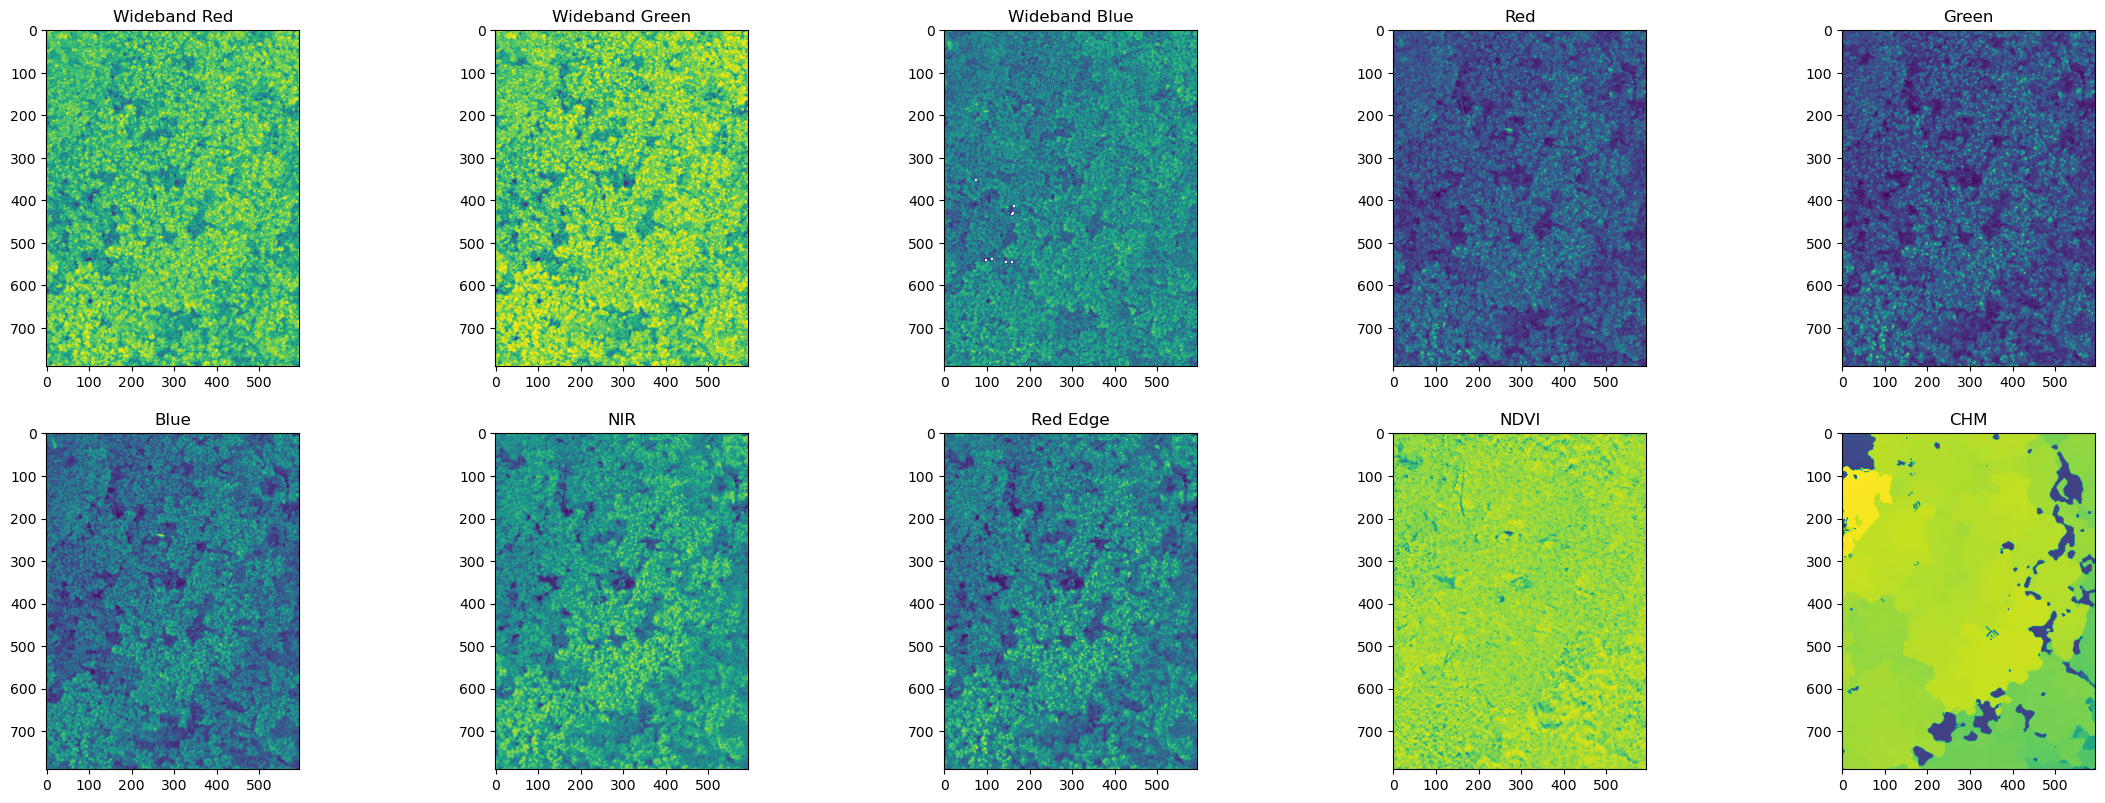

In [66]:
image = df.iloc[0]['itc']
fig, ax = plt.subplots(2, 5, figsize=(5.6*5, 4.8*2))
for ax, band in zip(ax.flatten(), bands):
    ax.imshow(image[:,:,bands.index(band)])
    ax.set_title(bands_readable[band])

## Produce noised crops at multiple z-levels

### Produce crops

In [68]:
def crop_center(img,cropx,cropy):
    y,x = img.shape[:2]
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[starty:starty+cropy,startx:startx+cropx]

In [69]:
df['crop'] = None
for idx, row in df.iterrows():
    crop = crop_center(row['itc'], 64, 64)
    crop = row['itc']
    df.at[idx, 'crop'] = [crop]
df = df.explode('crop')

In [70]:
df.columns

Index(['bc_index', '_ignore', 'name', 'y0', 'y1', 'x0', 'x1', 'src', 'itc',
       'dims', 'crop'],
      dtype='object')

In [71]:
df = df.set_index(['bc_index'])

In [72]:
df.columns

Index(['_ignore', 'name', 'y0', 'y1', 'x0', 'x1', 'src', 'itc', 'dims',
       'crop'],
      dtype='object')

#### Remove NDVI nans

In [73]:
df['crop'] = df['crop'].apply(lambda x: np.nan_to_num(x))

### Check crop

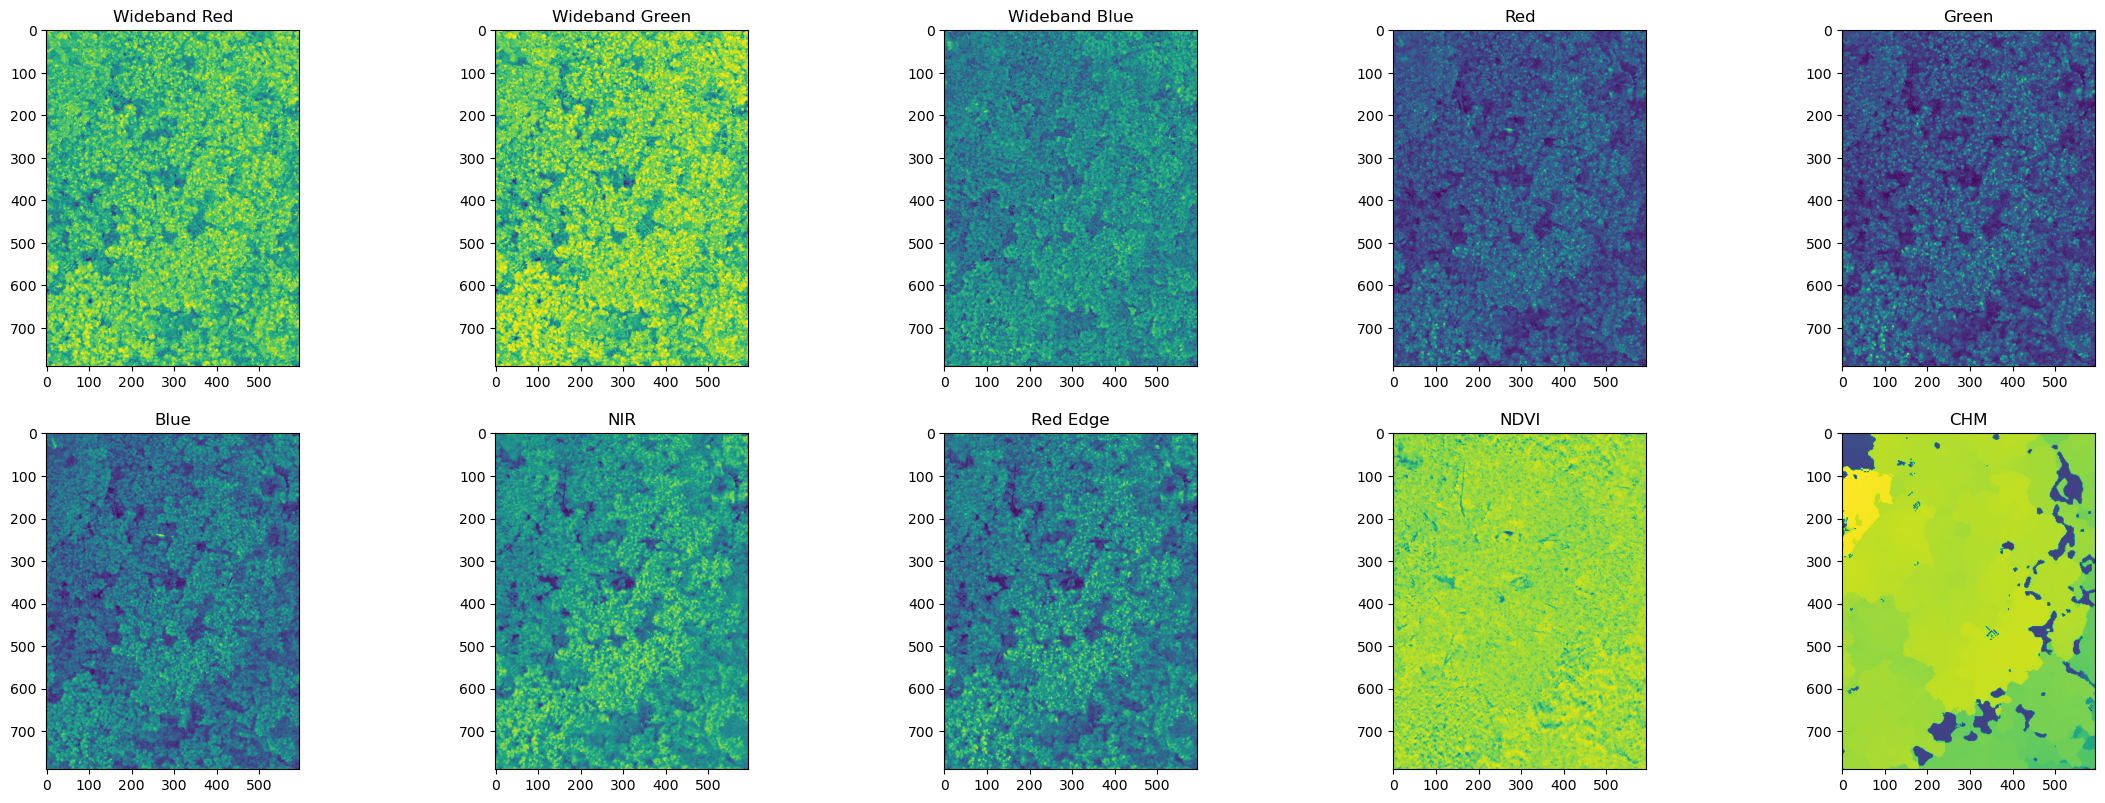

In [74]:
image = df.iloc[0]['crop']
fig, ax = plt.subplots(2, 5, figsize=(5.6*5, 4.8*2))
for ax, band in zip(ax.flatten(), bands):
    ax.imshow(image[:,:,bands.index(band)])
    ax.set_title(bands_readable[band])

### Check binning

#### Binning of crops

In [75]:
band_maxes = np.asarray([max([np.nanmax(df['crop'].iloc[j][:,:,i]) for j in range(len(df.index))]) for i in [*range(8), -1]])
print(list(band_maxes))

[255.0, 255.0, 255.0, 9078.421875, 8151.54248046875, 4525.32275390625, 15971.091796875, 15825.3212890625, 87.48914337158203]


In [76]:
band_mins = np.asarray([min([np.nanmin(df['crop'].iloc[j][:,:,i]) for j in range(len(df.index))]) for i in [*range(8), -1]])
print(list(band_mins))

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [77]:
print([(math.ceil(math.log(i,2))) for i in band_maxes[[*range(8), -1]]])

[8, 8, 8, 14, 13, 13, 14, 14, 7]


In [78]:
print([2**(math.ceil(math.log(i,2))) for i in band_maxes[[*range(8), -1]]])

[256, 256, 256, 16384, 8192, 8192, 16384, 16384, 128]


#### Binning of whole image

In [79]:
band_maxes = np.asarray([max([np.nanmax(j[:,:,i]) for j in [img_18Dec2020, img_10May2021]]) for i in [*range(8), -1]])
print(list(band_maxes))

[255.0, 255.0, 255.0, 9078.421875, 8151.54248046875, 4525.32275390625, 16181.4404296875, 15825.3212890625, 87.48914337158203]


In [80]:
band_mins = np.asarray([min([np.nanmin(j[:,:,i]) for j in [img_18Dec2020, img_10May2021]]) for i in [*range(8), -1]])
print(list(band_mins))

[1.0, 1.0, 1.0, 10.435933113098145, 51.14345932006836, 42.420528411865234, 190.29510498046875, 173.3649444580078, 46.586647033691406]


In [81]:
print([(math.ceil(math.log(i,2))) for i in band_maxes[[*range(8), -1]]])

[8, 8, 8, 14, 13, 13, 14, 14, 7]


In [82]:
print([2**(math.ceil(math.log(i,2))) for i in band_maxes[[*range(8), -1]]])

[256, 256, 256, 16384, 8192, 8192, 16384, 16384, 128]


#### Distribution of values in crops.

0it [00:00, ?it/s]

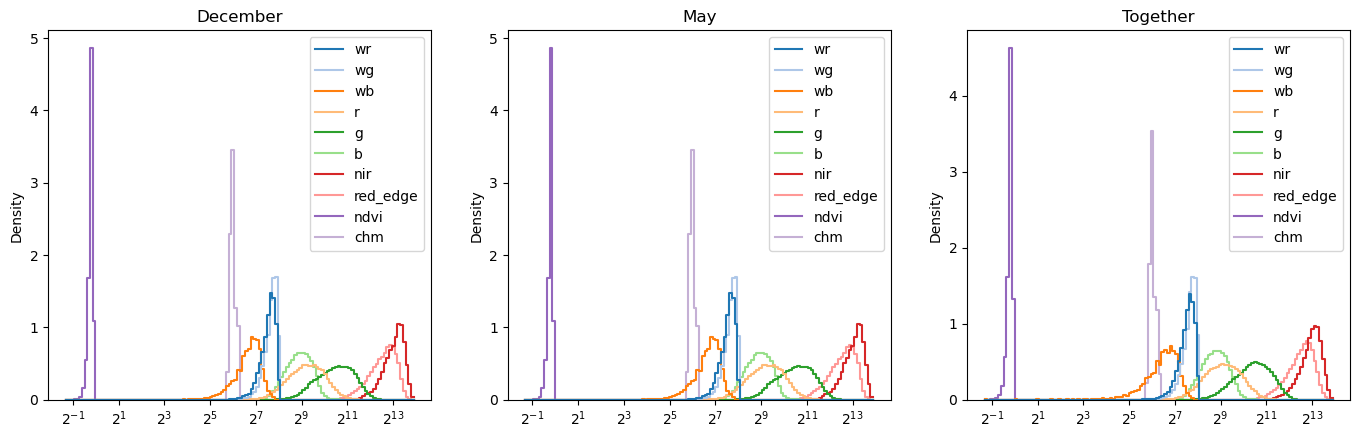

In [107]:
fig, axes = plt.subplots(1, 3, figsize=(5.6*3, 4.8))
for ax, df_, title in tqdm(zip(axes,
                               [df[df['src']=='18Dec2020'],
                                df[df['src']!='10May2021'],
                                df],
                               ['December', 'May', 'Together'])):
    sns.histplot(
        data=pd.DataFrame(
            np.stack(
                [
                    np.concatenate(
                        [
                            np.clip(crop_center(df_['crop'].iloc[j][:,:,i], 64, 64).flatten(),
                                    0.4, None)
                            for j in range(len(df_.index))
                        ]
                    )
                    for i in range(len(bands))
                ]
            ).T,
            columns=bands
        ),
        palette='tab20',
        log_scale=2,
        stat='density', common_norm=False,
        bins=128,
        element='step', fill=False,
        #alpha=0.15,
        ax=ax
    )
    ax.set_title(title)

### Perform binning

In [91]:
divby = [2, 2, 2, 16, 32, 8, 128, 128, 1, 1]

In [92]:
df_train = df[df['src']=='18Dec2020']

In [93]:
df_train_vals = np.concatenate(
    [
        df_train['crop'].iloc[j].reshape((-1, len(bands)))
        for j in range(len(df_train.index))
    ], axis=0)

In [94]:
band_bot_train = np.asarray([np.nanpercentile(df_train_vals[:,i], 1) for i in range(10)])
print(list(band_bot_train))

[79.0, 97.0, 34.0, 140.99864807128907, 313.56809387207034, 174.1493896484375, 2984.770703125, 1665.5184448242187, 0.6105872869491578, 53.600677490234375]


In [95]:
band_top_train = np.asarray([np.nanpercentile(df_train_vals[:,i], 99) for i in range(10)])
print(list(band_top_train))

[252.0, 255.0, 203.0, 2157.0858398437504, 4129.690869140626, 1214.263146972658, 13612.885546875, 11726.739257812504, 0.9482909858226776, 77.91827926635742]


In [96]:
df_binned = df.copy()

In [97]:
for idx, row in tqdm(df.iterrows()):
    crop = row['crop'].copy()
    #crop = ((crop - band_bot_train) / (band_top_train - band_bot_train) * 127)
    crop = crop / divby
    crop[:,:,8] -= 0.5
    crop[:,:,8] *= 255
    #crop[:,:,9] -= 30
    #crop[:,:,9] /= (90-30)
    #crop[:,:,9] *= 127
    crop = np.clip(crop.astype('uint8'), 0, 127)
    df_binned.at[idx,'crop'] = crop

0it [00:00, ?it/s]

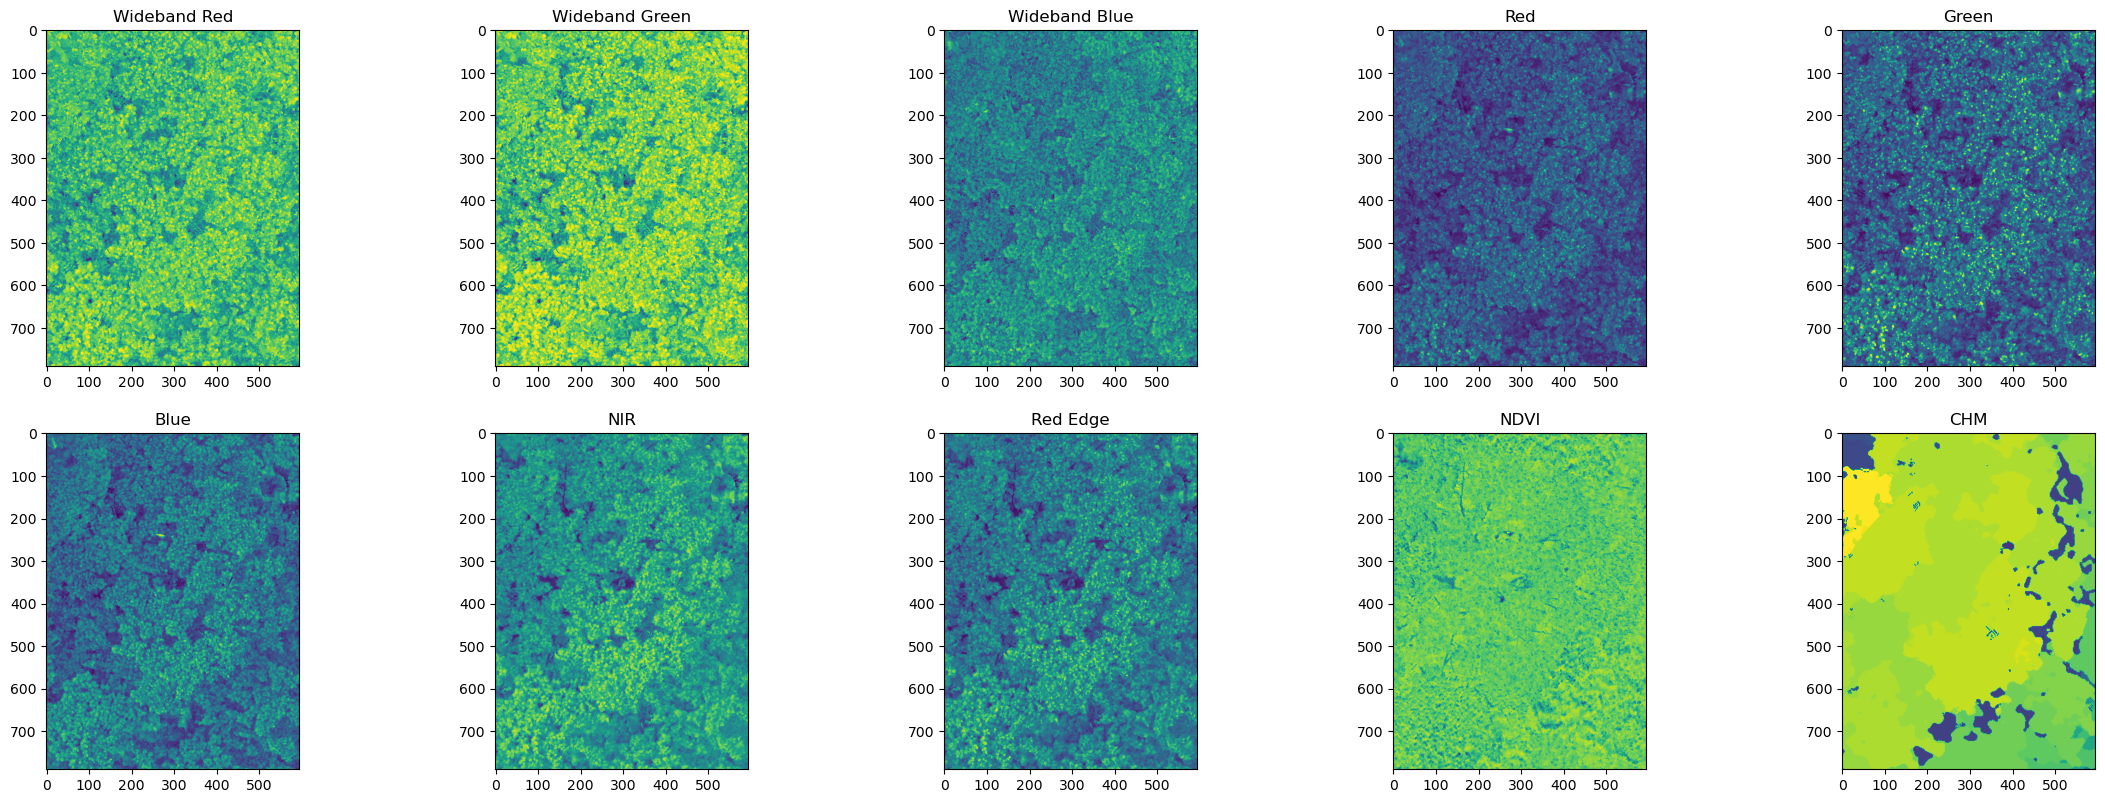

In [99]:
image = df_binned[df['src']!='18Dec2020'].iloc[0]['crop']
fig, ax = plt.subplots(2, 5, figsize=(5.6*5, 4.8*2))
for ax, band in zip(ax.flatten(), bands):
    ax.imshow(image[:,:,bands.index(band)])
    ax.set_title(bands_readable[band])

0it [00:00, ?it/s]

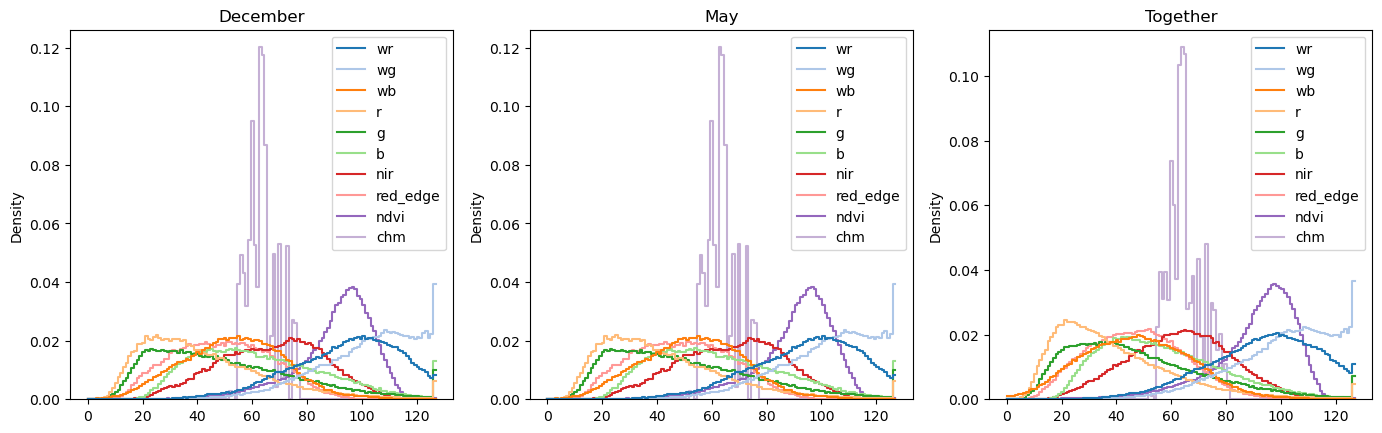

In [109]:
fig, axes = plt.subplots(1, 3, figsize=(5.6*3, 4.8))
for ax, df_, title in tqdm(zip(axes,
                               [df_binned[df_binned['src']=='18Dec2020'],
                                df_binned[df_binned['src']!='10May2021'],
                                df_binned],
                               ['December', 'May', 'Together'])):
    sns.histplot(
        data=pd.DataFrame(
            np.stack(
                [
                    np.concatenate(
                        [
                            crop_center(df_['crop'].iloc[j][:,:,i], 64, 64).flatten()
                            for j in range(len(df_.index))
                        ]
                    )
                    for i in range(len(bands))
                ]
            ).T,
            columns=bands
        ),
        palette='tab20',
        log_scale=False,
        stat='density', common_norm=False,
        bins=128,
        element='step', fill=False,
        #alpha=0.15,
        ax=ax
    )
    ax.set_title(title)

### Check binning

In [110]:
band_maxes_ = [max([np.max(df_binned['crop'].iloc[j][:,:,i]) for j in range(len(df.index))]) for i in range(8)]
print(band_maxes_)

[127, 127, 127, 127, 127, 127, 124, 123]


In [111]:
band_mins_ = [min([np.min(df_binned['crop'].iloc[j][:,:,i]) for j in range(len(df.index))]) for i in range(8)]
print(band_mins_)

[0, 0, 0, 0, 0, 0, 0, 0]


### Multiple z-levels

In [112]:
z_levels = np.asarray([1, 2, 4, 8])
zl_side_px = 64 // z_levels

In [113]:
zl_u = z_levels
zl_sp_u = zl_side_px
zl_sp_u

array([64, 32, 16,  8], dtype=int32)

In [114]:
df_nc = df_binned.copy()[['crop']]

In [115]:
z_crops = 64
for zl, zl_sp in tqdm(zip(zl_u, zl_sp_u), total=len(zl_u)):
    for i in ['x', 'y']:
        df_nc['zl_{}_corner_{}'.format(zl, i)] = None
        for idx, l in zip(df_nc.index,
                          np.random.randint(0, zl_sp+1 if zl!=1 else 1, (len(df_nc), z_crops))):
            df_nc.at[idx, 'zl_{}_corner_{}'.format(zl, i)] = l
for idx in tqdm(df_nc.index, total=len(df)):
    randxoff = np.random.randint(df_nc.at[idx, 'crop'].shape[0] - zl_sp_u[0])
    randyoff = np.random.randint(df_nc.at[idx, 'crop'].shape[1] - zl_sp_u[0])
    df_nc.at[idx, 'zl_1_corner_x'.format(zl)] += randxoff
    df_nc.at[idx, 'zl_1_corner_y'.format(zl)] += randyoff

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

In [116]:
df_nc = df_nc.reset_index()

In [117]:
df_nc = df_nc.explode(list(df_nc.columns[2:]), ignore_index=True)

In [118]:
df_nc = df_nc.reset_index() 

In [119]:
df_nc = df_nc.rename(columns={'index': 'zc_iter'})

In [120]:
df_nc['zc_iter'] %= z_crops

In [121]:
df_nc = df_nc.set_index(['bc_index', 'zc_iter'])

In [122]:
for zl, zl_sp in zip(zl_u, zl_sp_u):
    df_nc['zl_{}_crop'.format(zl)] = None
for idx, row in tqdm(df_nc.iterrows(), total=len(df_nc)):
    xadd, yadd = 0, 0
    for zl, zl_sp in zip(zl_u, zl_sp_u):
        c_x = row['zl_{}_corner_x'.format(zl)]
        c_y = row['zl_{}_corner_y'.format(zl)]
        df_nc.at[idx,'zl_{}_crop'.format(zl)] = row['crop'][xadd+c_x:,yadd+c_y:][:zl_sp,:zl_sp]
        xadd += c_x
        yadd += c_y

  0%|          | 0/4224 [00:00<?, ?it/s]

In [123]:
df_nc.iloc[-1,:].apply(lambda x: x[:,:,0].size if isinstance(x, np.ndarray) else float('nan'))

crop             113146.0
zl_1_corner_x         NaN
zl_1_corner_y         NaN
zl_2_corner_x         NaN
zl_2_corner_y         NaN
zl_4_corner_x         NaN
zl_4_corner_y         NaN
zl_8_corner_x         NaN
zl_8_corner_y         NaN
zl_1_crop          4096.0
zl_2_crop          1024.0
zl_4_crop           256.0
zl_8_crop            64.0
Name: (66, 63), dtype: float64

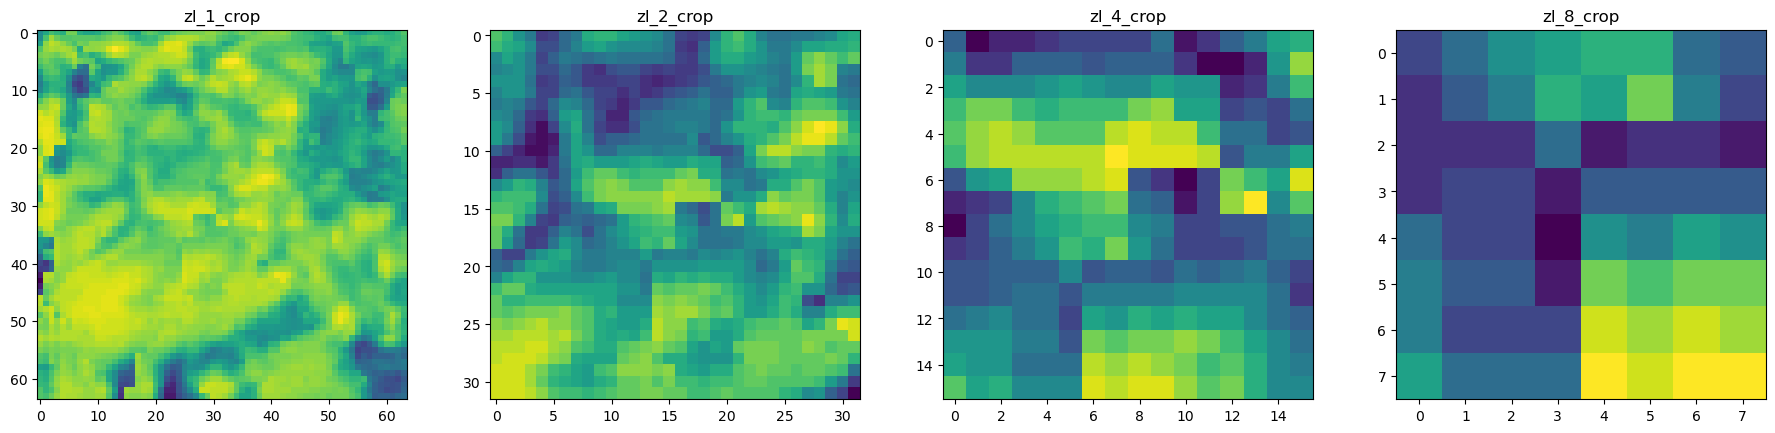

In [136]:
image = [row[col][:,:,0] for idx, row in df_nc.sample(4, random_state=42).iterrows() for col in df_nc.columns if '_crop' in col]
fig, ax = plt.subplots(1, 4, figsize=(5.6*4, 4.8*1))
cols = [col for col in df_nc.columns if '_crop' in col]
for ax, col in zip(ax.flatten(), cols):
    ax.imshow(image[cols.index(col)])
    ax.set_title(col)

### Noising

In [137]:
def noise_image(arr):
    noise = np.random.choice([0, 1], size=arr.shape, replace=True, p=[0.2, 0.8])
    return np.where(noise, arr, 128)

In [138]:
df_noise = pd.DataFrame(index=df_nc.index, columns=[*df_nc.columns[9:], 'n_iter'])

In [140]:
n_crops = 1
zlevels = [1, 2, 4, 8]
for idx, row in tqdm(df_nc.iterrows(), total=len(df_nc)):
    for zl in zlevels:
        noised = []
        for i in range(n_crops):
            if zl == 1 or True:
                noised.append(noise_image(row['zl_{}_crop'.format(zl)]))
            else:
                noised.append(row['zl_{}_crop'.format(zl)])
        df_noise.at[idx, 'zl_{}_crop'.format(zl)] = noised
        df_noise.at[idx, 'n_iter'] = range(n_crops)
df_noise = df_noise.explode([*['zl_{}_crop'.format(zl) for zl in zlevels], 'n_iter'])

  0%|          | 0/4224 [00:00<?, ?it/s]

In [141]:
df_noise = df_noise.reset_index()

In [142]:
df_noise.columns

Index(['bc_index', 'zc_iter', 'zl_1_crop', 'zl_2_crop', 'zl_4_crop',
       'zl_8_crop', 'n_iter'],
      dtype='object')

In [143]:
df_noise = df_noise.set_index(['bc_index', 'zc_iter', 'n_iter'])

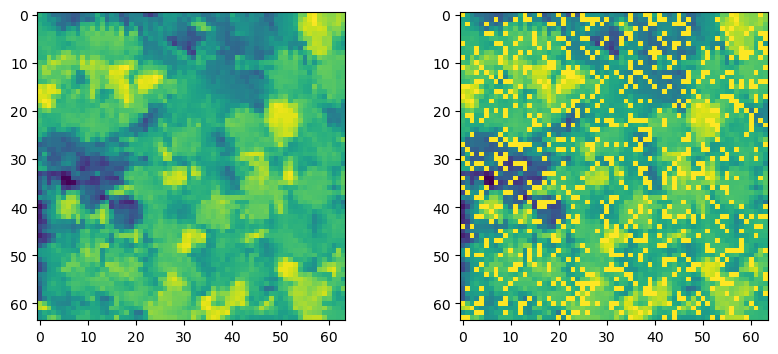

In [144]:
f, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].imshow(df_nc.iloc[12]['zl_1_crop'][:,:,0])
ax[1].imshow(df_noise.iloc[12]['zl_1_crop'][:,:,0])

In [145]:
df_noise.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 4224 entries, (0, 0, 0) to (66, 63, 0)
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   zl_1_crop  4224 non-null   object
 1   zl_2_crop  4224 non-null   object
 2   zl_4_crop  4224 non-null   object
 3   zl_8_crop  4224 non-null   object
dtypes: object(4)
memory usage: 149.8+ KB


In [146]:
collectAll()

146834

### Save dataframes

In [147]:
df.to_pickle('df.pickle')

In [148]:
df_nc.to_pickle('df_nc.pickle')

In [149]:
df_noise.to_pickle('df_noise.pickle')

### Reload

In [150]:
df = pd.read_pickle('df.pickle')

In [151]:
df_noise = pd.read_pickle('df_noise.pickle')

In [152]:
bands = ['wr', 'wg', 'wb', 'r', 'g', 'b', 'nir', 'red_edge', 'ndvi', 'chm']
props = ['mean_no_glcm', 'mean', 'var', 'contrast', 'dissimilarity', 'homogeneity', 'ASM', 'energy', 'correlation']

In [153]:
collectAll()

27654

In [154]:
df.iloc[:,[i for i in range(len(df.columns)) if i not in [7]]].head(1)

_ignore                  name    y0    y1    x0    x1        src  \
bc_index                                                                     
0               0  Falcataria Moluccana  2310  3100  2323  2918  10May2021   

                dims                                               crop  
bc_index                                                                 
0         (790, 595)  [[[228.0, 242.0, 102.0, 521.6130981445312, 122...

In [155]:
df_noise.head(1)

zl_1_crop  \
bc_index zc_iter n_iter                                                      
0        0       0       [[[88, 89, 52, 28, 25, 128, 26, 16, 67, 81], [...   

                                                                 zl_2_crop  \
bc_index zc_iter n_iter                                                      
0        0       0       [[[97, 106, 38, 128, 52, 53, 65, 52, 128, 128]...   

                                                                 zl_4_crop  \
bc_index zc_iter n_iter                                                      
0        0       0       [[[92, 98, 49, 32, 28, 64, 32, 23, 70, 81], [9...   

                                                                 zl_8_crop  
bc_index zc_iter n_iter                                                     
0        0       0       [[[128, 108, 55, 48, 66, 42, 128, 128, 86, 81]...

### Discard part

In [156]:
df_noise.index

MultiIndex([( 0,  0, 0),
            ( 0,  1, 0),
            ( 0,  2, 0),
            ( 0,  3, 0),
            ( 0,  4, 0),
            ( 0,  5, 0),
            ( 0,  6, 0),
            ( 0,  7, 0),
            ( 0,  8, 0),
            ( 0,  9, 0),
            ...
            (66, 54, 0),
            (66, 55, 0),
            (66, 56, 0),
            (66, 57, 0),
            (66, 58, 0),
            (66, 59, 0),
            (66, 60, 0),
            (66, 61, 0),
            (66, 62, 0),
            (66, 63, 0)],
           names=['bc_index', 'zc_iter', 'n_iter'], length=4224)

In [157]:
[i for i in range(100)[slice(0,4)]]

[0, 1, 2, 3]

In [158]:
df_noise = df_noise.loc[(slice(None),slice(None),slice(None)),:].copy()
collectAll()

0

In [159]:
df_noise.shape

(4224, 4)

In [160]:
df_noise.to_pickle('df_noise_smaller.pickle')

### Reload again

In [161]:
df = pd.read_pickle('df.pickle')

In [162]:
df_noise = pd.read_pickle('df_noise_smaller.pickle')

In [163]:
bands = ['wr', 'wg', 'wb', 'r', 'g', 'b', 'nir', 'red_edge', 'ndvi']#, 'chm']
props = ['mean_no_glcm', 'mean', 'var', 'contrast', 'dissimilarity', 'homogeneity', 'ASM', 'energy', 'correlation']

In [164]:
collectAll()

0

## Produce GLCM-property features

In [166]:
df_noise.iloc[0]['zl_2_crop'].shape

(32, 32, 10)

In [171]:
def windows_glcm_runner(x):
    import numpy as np
    from skimage.feature import graycomatrix
    from skimage.feature import graycoprops
    from math import pi

    bands = ['wr', 'wg', 'wb', 'r', 'g', 'b', 'nir', 'red_edge', 'ndvi']#, 'chm']
    props = ['mean_no_glcm', 'mean', 'var', 'contrast', 'dissimilarity', 'homogeneity', 'ASM', 'energy', 'correlation']

    distances = [1]
    angles = [0, 0.25*pi, 0.5*pi, 0.75*pi, pi, 1.25*pi, 1.5*pi, 1.75*pi]
    levels = 129
    symmetric = False
    normed = True
    
    def glcms_from_crop(crop):
        glcms = np.stack([graycomatrix(crop[:,:,i], distances=distances, angles=angles,
                                  levels=levels, symmetric=symmetric, normed=False)
                     for i in range(8)], axis=-1)[:128,:128]
        if normed:
            return norm(glcms)
        else:
            return glcms
    
    def norm(glcms):
        return glcms / np.sum(glcms, axis=(0,1,2,3), keepdims=True)
    
    def graycomean(glcm):
        return np.sum(glcm.T * np.arange(glcm.shape[0]))
    
    def graycovar(glcm, mean):
        return np.sum(glcm.T * np.square(np.arange(glcm.shape[0]) - mean)) 
    
    props = ['mean_no_glcm', 'mean', 'var', 'contrast', 'dissimilarity', 'homogeneity', 'ASM', 'energy', 'correlation']
    
    def graycoprops_from_glcms(glcms, crop):
        new_dict = {}
        for band in bands[:-2]:
            new_dict[(band, 'mean_no_glcm')] = np.mean(crop[:,:,bands.index(band)])
            if band in ['ndvi', 'chm']:
                continue
            mean = graycomean(glcms[:,:,:,:,bands.index(band)])
            new_dict[(band, 'mean')] = mean
            new_dict[(band, 'var')] = graycovar(glcms[:,:,:,:,bands.index(band)], mean)
            for prop in props[3:]:             
                new_dict[(band, prop)] = graycoprops(glcms[:,:,:,:,bands.index(band)], prop).mean()
        return new_dict

    return graycoprops_from_glcms(glcms_from_crop(x[:,:,:-2]), x[:,:,:])

In [173]:
for col in df_noise.columns:
    print(col)
    df_noise[col+'_props'] = df_noise.iloc[:][col].parallel_apply(windows_glcm_runner)

zl_1_crop


zl_2_crop


zl_4_crop


zl_8_crop


In [174]:
collectAll()

1028

In [176]:
df_glcm = df_noise[[i for i in df_noise.columns if '_props' in i]]

In [177]:
df_glcm.to_pickle('df_glcm_intermediary.pickle')

In [183]:
df_glcm

zl_1_crop_props  \
bc_index zc_iter n_iter                                                      
0        0       0       {('wr', 'mean_no_glcm'): 94.571533203125, ('wr...   
         1       0       {('wr', 'mean_no_glcm'): 94.43408203125, ('wr'...   
         2       0       {('wr', 'mean_no_glcm'): 95.029296875, ('wr', ...   
         3       0       {('wr', 'mean_no_glcm'): 94.534912109375, ('wr...   
         4       0       {('wr', 'mean_no_glcm'): 94.506591796875, ('wr...   
...                                                                    ...   
66       59      0       {('wr', 'mean_no_glcm'): 104.091796875, ('wr',...   
         60      0       {('wr', 'mean_no_glcm'): 104.000732421875, ('w...   
         61      0       {('wr', 'mean_no_glcm'): 104.3798828125, ('wr'...   
         62      0       {('wr', 'mean_no_glcm'): 103.959228515625, ('w...   
         63      0       {('wr', 'mean_no_glcm'): 104.0322265625, ('wr'...   

                                                           zl_2_crop_props  \
bc_index zc_iter n_iter                                                      
0        0       0       {('wr', 'mean_no_glcm'): 91.75, ('wr', 'mean')...   
         1       0       {('wr', 'mean_no_glcm'): 99.1044921875, ('wr',...   
         2       0       {('wr', 'mean_no_glcm'): 92.123046875, ('wr', ...   
         3       0       {('wr', 'mean_no_glcm'): 99.0732421875, ('wr',...   
         4       0       {('wr', 'mean_no_glcm'): 92.7119140625, ('wr',...   
...                                                                    ...   
66       59      0       {('wr', 'mean_no_glcm'): 97.14453125, ('wr', '...   
         60      0       {('wr', 'mean_no_glcm'): 108.931640625, ('wr',...   
         61      0       {('wr', 'mean_no_glcm'): 101.3505859375, ('wr'...   
         62      0       {('wr', 'mean_no_glcm'): 101.775390625, ('wr',...   
         63      0       {('wr', 'mean_no_glcm'): 104.9013671875, ('wr'...   

                                                           zl_4_crop_props  \
bc_index zc_iter n_iter                                                      
0        0       0       {('wr', 'mean_no_glcm'): 89.1953125, ('wr', 'm...   
         1       0       {('wr', 'mean_no_glcm'): 99.58203125, ('wr', '...   
         2       0       {('wr', 'mean_no_glcm'): 93.34375, ('wr', 'mea...   
         3       0       {('wr', 'mean_no_glcm'): 97.1484375, ('wr', 'm...   
         4       0       {('wr', 'mean_no_glcm'): 89.41796875, ('wr', '...   
...                                                                    ...   
66       59      0       {('wr', 'mean_no_glcm'): 96.85546875, ('wr', '...   
         60      0       {('wr', 'mean_no_glcm'): 112.63671875, ('wr', ...   
         61      0       {('wr', 'mean_no_glcm'): 99.3203125, ('wr', 'm...   
         62      0       {('wr', 'mean_no_glcm'): 102.921875, ('wr', 'm...   
         63      0       {('wr', 'mean_no_glcm'): 103.328125, ('wr', 'm...   

                                                           zl_8_crop_props  
bc_index zc_iter n_iter                                                     
0        0       0       {('wr', 'mean_no_glcm'): 90.9375, ('wr', 'mean...  
         1       0       {('wr', 'mean_no_glcm'): 88.203125, ('wr', 'me...  
         2       0       {('wr', 'mean_no_glcm'): 89.921875, ('wr', 'me...  
         3       0       {('wr', 'mean_no_glcm'): 96.890625, ('wr', 'me...  
         4       0       {('wr', 'mean_no_glcm'): 93.828125, ('wr', 'me...  
...                                                                    ...  
66       59      0       {('wr', 'mean_no_glcm'): 105.65625, ('wr', 'me...  
         60      0       {('wr', 'mean_no_glcm'): 105.46875, ('wr', 'me...  
         61      0       {('wr', 'mean_no_glcm'): 93.296875, ('wr', 'me...  
         62      0       {('wr', 'mean_no_glcm'): 102.671875, ('wr', 'm...  
         63      0       {('wr', 'mean_no_glcm'): 103.53125, ('wr', 'me...  

[4224 rows x

### Fix our columns

In [178]:
bands = ['wr', 'wg', 'wb', 'r', 'g', 'b', 'nir', 'red_edge', 'ndvi', 'chm']
props = ['mean_no_glcm', 'mean', 'var', 'contrast', 'dissimilarity', 'homogeneity', 'ASM', 'energy', 'correlation']

In [179]:
df_glcm_new = pd.DataFrame(index=df_glcm.index)

In [184]:
for col in df_glcm.columns:
    df_glcm_new = pd.concat((df_glcm_new, df_glcm[col].progress_apply(pd.Series)), axis=1)
    df_glcm_new.columns = [(col, *ij) if isinstance(ij, tuple) and len(ij) == 2 else ij for ij in df_glcm_new.columns]

  0%|          | 0/4224 [00:00<?, ?it/s]

  0%|          | 0/4224 [00:00<?, ?it/s]

  0%|          | 0/4224 [00:00<?, ?it/s]

  0%|          | 0/4224 [00:00<?, ?it/s]

In [185]:
df_glcm.columns

Index(['zl_1_crop_props', 'zl_2_crop_props', 'zl_4_crop_props',
       'zl_8_crop_props'],
      dtype='object')

In [186]:
df_glcm_new.columns

Index([  ('zl_1_crop_props', 'wr', 'mean_no_glcm'),
                 ('zl_1_crop_props', 'wr', 'mean'),
                  ('zl_1_crop_props', 'wr', 'var'),
             ('zl_1_crop_props', 'wr', 'contrast'),
        ('zl_1_crop_props', 'wr', 'dissimilarity'),
          ('zl_1_crop_props', 'wr', 'homogeneity'),
                  ('zl_1_crop_props', 'wr', 'ASM'),
               ('zl_1_crop_props', 'wr', 'energy'),
          ('zl_1_crop_props', 'wr', 'correlation'),
         ('zl_1_crop_props', 'wg', 'mean_no_glcm'),
       ...
           ('zl_8_crop_props', 'b', 'correlation'),
        ('zl_8_crop_props', 'nir', 'mean_no_glcm'),
                ('zl_8_crop_props', 'nir', 'mean'),
                 ('zl_8_crop_props', 'nir', 'var'),
            ('zl_8_crop_props', 'nir', 'contrast'),
       ('zl_8_crop_props', 'nir', 'dissimilarity'),
         ('zl_8_crop_props', 'nir', 'homogeneity'),
                 ('zl_8_crop_props', 'nir', 'ASM'),
              ('zl_8_crop_props', 'nir', 'energy'),
 

### Save our GLCM props dataframe.

In [187]:
df_glcm_new.to_pickle('df_glcm3.pickle')

In [188]:
df[['name', 'src']].to_pickle('df_metadata.pickle')

### Reload

In [189]:
df_glcm = pd.read_pickle('df_glcm3.pickle')
collectAll()

17